## Final ILU (Information Location and Usage) Proof of Concept

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class Movie():
    
    '''
    A base class that creates a Movie object.
    '''
    
    def __init__(self, title, release_year, movie_runtime, genres, rating, synopsis, director, stars, votes, gross):
        self.title = title
        self.release_year = release_year
        self.movie_runtime = movie_runtime
        self.genres = genres
        self.rating = rating
        self.synopsis = synopsis
        self.director = director
        self.stars = stars
        self.votes = votes
        self.gross = gross
        
        
    def to_dict(self):
        return {'Title': self.title,
                'Release Year': self.release_year,
                'Movie Runtime': self.movie_runtime,
                'Genres': self.genres,
                'Rating': self.rating,
                'Synopsis': self.synopsis,
                'Director': self.director,
                'Stars': self.stars,
                'Votes': self.votes,
                'Gross': self.gross
               }

        
        
        
class IMDB_Movie_Lib():
    
    '''
    A Scrapper class that parses the titles from the IMDB webpage.
    '''
    
    def __init__(self, url, page_count=1):
        self.url = url
        self.page_count = page_count
        self.movies = []
        self.__get_movies_list()
            
    
    def __get_next_page(self):
        try:
            next_url = self.soup.find('div', class_='desc').find_all('a')[-1]['href']
            self.url = 'https://imdb.com' + next_url
            return True
        except:
            print(f'''There are no pages left.
                  Total amount of pages parsed of {self.page} pages.''')
            return False
    
    
    def __get_content(self):
        '''
        Get the HTML content.
        '''
        
        r = requests.get(self.url)
        code = r.status_code
        assert code == 200, f'Something went wrong when requesting the HTML.'
        self.soup = BeautifulSoup(r.content, features='lxml')
    
    
    def __get_movies(self):
        self.__get_content()
        yield from self.soup.find_all('div', class_='lister-item mode-advanced')
    
    
    def __get_title(self, movie):
        return movie.find('h3', class_='lister-item-header').text.split('\n')[2]
    
    
    def __get_release_year(self, movie):
        try:
            release_year = movie.find('h3', class_='lister-item-header').text.split('\n')[3].split('–')[0].lower()
            return int(re.sub(pattern=r'[()]|[a-z]| ', repl='', string=release_year))
        except:
            return 'N/A'
    
    
    def __get_runtime(self, movie):
        try:
            movie_runtime = movie.find('span', class_='runtime').text
            return movie_runtime
        except:
            return 'N/A'
    
    
    def __get_genres(self, movie):
        try:
            genre = movie.find('span', class_='genre').text
            return re.sub(pattern='  +|\n', repl='', string=genre)
        except:
            return 'N/A'
    
    
    def __get_rating(self, movie):
        try:
            rating = movie.find('div', class_='ratings-bar').div.strong.text
            return float(rating)
        except:
            return 'N/A'
        
        
    def __get_synopsis(self, movie):
        try:
            synopsis = movie.find_all('p', class_='text-muted')[1].text
            return re.sub(pattern='  +|\n', repl='', string=synopsis)
        except:
            return 'N/A'
        
    
    def __get_director(self, movie):
        if movie.find('p', class_='').find('span', class_='ghost') is not None:
            director = movie.find('p', class_='').text.split('|')[0].split(':')[1]
            director = re.sub(pattern='  +|\n', repl='', string=director)
            return director
        else:
            return 'N/A'
        
    
    def __get_stars(self, movie):
        try:
            stars = movie.find('p', class_='').text.split('|')[1].split(':')[1]
            stars = re.sub(pattern='  +|\n', repl='', string=stars)
            return stars
        except:
            stars = movie.find('p', class_='').text.split('|')[0].split(':')[1]
            stars = re.sub(pattern='  +|\n', repl='', string=stars)
            return stars
        else:
            return 'N/A'
        
        
    def __get_votes(self, movie):
        try:
            votes = movie.find('p', class_='sort-num_votes-visible').text.split('\n')[2]
            return int(re.sub(pattern='  +|\n', repl='', string=votes).replace(',', ''))
        except:
            return 'N/A'
        
        
    def __get_gross(self, movie):
        try:
            if movie.find('p', class_='sort-num_votes-visible').find('span', class_='ghost') is not None:
                gross = movie.find('p', class_='sort-num_votes-visible').text.split('\n')[-2]
                return re.sub(pattern='  +|\n', repl='', string=gross)
            else:
                return 'N/A'
        except:
            return 'N/A'
    
    
    def __get_movies_list(self):
        assert self.page_count >= 1, 'The number of pages must be greater or equals to one.'
        self.page = 1
        
        for page in range(self.page_count):
            for movie in self.__get_movies():
                self.movies.append(
                    Movie(
                        title=self.__get_title(movie),
                        release_year=self.__get_release_year(movie),
                        movie_runtime=self.__get_runtime(movie),
                        genres=self.__get_genres(movie),
                        rating=self.__get_rating(movie),
                        synopsis=self.__get_synopsis(movie),
                        director=self.__get_director(movie),
                        stars=self.__get_stars(movie),
                        votes=self.__get_votes(movie),
                        gross=self.__get_gross(movie)
                    )
                )
            self.page += 1
            if not self.__get_next_page():
                break
        
    def __len__(self):
        return len(self.movies)
    
    
    def list_movies(self):
        '''
        Returns a DataFrame object containing all the parsed movies.
        '''
        data = [movie.to_dict() for movie in self.movies]
        return pd.DataFrame(data=data)
        
        

if __name__ == '__main__':
    url = 'https://www.imdb.com/search/title?count=100&title_type=feature,tv_series&ref_=nv_wl_img_2'
    imdb_movies = IMDB_Movie_Lib(url, page_count=5)
    movies_df = imdb_movies.list_movies()

### Question 1 - Create a raw movies DataFrame object by scrapping the IMDB's webpage(s).

In [3]:
movies_df.head(10)

,Title,Release Year,Movie Runtime,Genres,Rating,Synopsis,Director,Stars,Votes,Gross
0,Zack Snyder's Justice League,2021,240 min,"Action, Adventure, Fantasy",N/A,Zack Snyder's definitive director's cut of Jus...,Zack Snyder,"Henry Cavill, Ben Affleck, Gal Gadot, Jared Leto",N/A,N/A
1,Mortal Kombat,2021,N/A,"Action, Adventure, Fantasy",N/A,MMA fighter Cole Young seeks out Earth's great...,Simon McQuoid,"Jessica McNamee, Hiroyuki Sanada, Josh Lawson,...",N/A,N/A
2,Cruella,2021,N/A,"Comedy, Crime",N/A,A live-action prequel feature film following a...,Craig Gillespie,"Emma Stone, Emma Thompson, Mark Strong, Paul W...",N/A,N/A
3,Judas e o Messias Negro,2021,126 min,"Biography, Drama, History",7.7,Bill O'Neal infiltrates the Black Panther Part...,Shaka King,"Daniel Kaluuya, LaKeith Stanfield, Jesse Plemo...",15241,N/A
4,The Sinner,2017,45 min,"Crime, Drama, Mystery",7.9,Anthology series that examines how and why ord...,N/A,"Bill Pullman, Dohn Norwood, Adam LeFevre, Jess...",88610,N/A
5,Amigas para Sempre,2021,N/A,"Drama, Romance",7.6,Tully and Kate support each other through good...,N/A,"Katherine Heigl, Sarah Chalke, Ben Lawson, Ali...",9448,N/A
6,Ataque dos Titãs,2013,24 min,"Animation, Action, Adventure",8.9,After his hometown is destroyed and his mother...,N/A,"Yûki Kaji, Marina Inoue, Yui Ishikawa, Josh Gr...",203957,N/A
7,Your Honor,2020,573 min,"Crime, Drama, Thriller",7.8,A judge confronts his convictions when his son...,N/A,"Bryan Cranston, Hunter Doohan, Hope Davis, Mic...",19817,N/A
8,Bridgerton,2020,60 min,"Drama, Romance",7.3,"Wealth, lust, and betrayal set against the bac...",N/A,"Phoebe Dynevor, Regé-Jean Page, Nicola Coughla...",63689,N/A
9,Relatos do Mundo,2020,118 min,"Action, Adventure, Drama",6.8,"A Civil War veteran agrees to deliver a girl, ...",Paul Greengrass,"Tom Hanks, Helena Zengel, Tom Astor, Travis Jo...",39753,N/A


### Question 2 - Create a movies DataFrame object and order the movies by genre.

In [4]:
genres_df = movies_df.copy(deep=True)

def text_split(string, sep, index=None):
    '''
    Splits a string and returns a list.
    If an index value is specified, then returns that element.
    If the specified index is out of range, then returns "N/A".
    
    Keyword arguments:
    string -- The string to be splitted.
    sep -- The separator.
    index -- The 
    '''
    try:
        return string.split(sep)[index] if index or index == 0 else string.split(sep)
    except:
        return 'N/A'

    
splitcount = max(genres_df['Genres'].apply(lambda x: len(text_split(string=x, sep=', ')))) #Returns the maximum length of a movie genres' list to be used to define the amount of individual Genre columns to be created. 
for i in range(splitcount):
    genres_df[f'Genre {i + 1}'] = genres_df['Genres'].apply(lambda x: text_split(string=x, sep=', ', index=i))

sorted_by_genre_df = genres_df.sort_values(by=['Genre 1', 'Genre 2', 'Genre 3']) #Sorting the DataFrame by genre.
sorted_by_genre_df

,Title,Release Year,Movie Runtime,Genres,Rating,Synopsis,Director,Stars,Votes,Gross,Genre 1,Genre 2,Genre 3
390,Spartacus,2010,55 min,"Action, Adventure, Biography",8.5,"The life of Spartacus, the gladiator who lead ...",N/A,"Andy Whitfield, Lucy Lawless, Manu Bennett, Da...",223859,N/A,Action,Adventure,Biography
117,Em busca de 'Ohana,2021,123 min,"Action, Adventure, Comedy",6.1,A summer in rural O‘ahu takes an exciting turn...,Jude Weng,"Kea Peahu, Alex Aiono, Lindsay Watson, Owen Va...",5505,N/A,Action,Adventure,Comedy
142,Thor: Ragnarok,2017,130 min,"Action, Adventure, Comedy",7.9,"Imprisoned on the planet Sakaar, Thor must rac...",Taika Waititi,"Chris Hemsworth, Tom Hiddleston, Cate Blanchet...",593537,$315.06M,Action,Adventure,Comedy
177,The Umbrella Academy,2019,60 min,"Action, Adventure, Comedy",8,"A family of former child heroes, now grown apa...",N/A,"Elliot Page, Tom Hopper, David Castañeda, Emmy...",160397,N/A,Action,Adventure,Comedy
191,Aves de Rapina: Arlequina e sua Emancipação Fa...,2020,109 min,"Action, Adventure, Comedy",6.1,"After splitting with the Joker, Harley Quinn j...",Cathy Yan,"Margot Robbie, Rosie Perez, Mary Elizabeth Win...",170918,$84.16M,Action,Adventure,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,Don't Worry Darling,N/A,N/A,"Horror, Thriller",N/A,A 1950's housewife living with her husband in ...,Olivia Wilde,"Olivia Wilde, Florence Pugh, Chris Pine, Gemma...",N/A,N/A,Horror,Thriller,N/A
455,Fragmentado,2016,117 min,"Horror, Thriller",7.3,Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",429122,$138.29M,Horror,Thriller,N/A
479,Pânico na Floresta,2003,84 min,"Horror, Thriller",6.1,Chris and a group of five friends are left str...,Rob Schmidt,"Eliza Dushku, Jeremy Sisto, Emmanuelle Chriqui...",110019,$15.42M,Horror,Thriller,N/A
224,Ilha do Medo,2010,138 min,"Mystery, Thriller",8.2,"In 1954, a U.S. Marshal investigates the disap...",Martin Scorsese,"Leonardo DiCaprio, Emily Mortimer, Mark Ruffal...",1138467,$128.01M,Mystery,Thriller,N/A


### Question 3 - Create a movies DataFrame object and order the movies by Release Year.

In [5]:
released_by_year_df = movies_df[movies_df['Release Year'] != 'N/A'].sort_values(by=['Release Year'], ascending=False) #Sorting the DataFrame by release year.
released_by_year_df

,Title,Release Year,Movie Runtime,Genres,Rating,Synopsis,Director,Stars,Votes,Gross
252,Doctor Strange in the Multiverse of Madness,2022,N/A,"Action, Adventure, Fantasy",N/A,Plot unknown. Sequel to the 2016 Marvel film '...,Sam Raimi,"Elizabeth Olsen, Rachel McAdams, Benedict Cumb...",N/A,N/A
221,The Batman,2022,N/A,"Action, Crime, Drama",N/A,The plot is unknown.,Matt Reeves,"Robert Pattinson, Colin Farrell, Zoë Kravitz, ...",N/A,N/A
199,Thor: Love and Thunder,2022,N/A,"Action, Adventure, Fantasy",N/A,The sequel to Thor: Ragnarok and the fourth mo...,Taika Waititi,"Karen Gillan, Natalie Portman, Taika Waititi, ...",N/A,N/A
299,Amor²,2021,102 min,"Comedy, Romance",4.9,A celebrity journalist and renowned womanizer ...,Filip Zylber,"Adrianna Chlebicka, Mateusz Banasiuk, Agnieszk...",1749,N/A
80,Palmer,2021,110 min,Drama,7.3,An ex-convict strikes up a friendship with a b...,Fisher Stevens,"Justin Timberlake, Juno Temple, Alisha Wainwri...",16487,N/A
...,...,...,...,...,...,...,...,...,...,...
392,Os Pioneiros,1974,60 min,"Drama, Family, Romance",7.4,The life and adventures of the Ingalls family ...,N/A,"Melissa Gilbert, Michael Landon, Karen Grassle...",18409,N/A
173,O Poderoso Chefão,1972,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1630338,$134.97M
435,Columbo,1971,100 min,"Crime, Drama, Mystery",8.2,Los Angeles homicide detective Lieutenant Colu...,N/A,"Peter Falk, Mike Lally, John Finnegan, Bruce K...",28369,N/A
430,Jornada nas Estrelas,1966,50 min,"Action, Adventure, Sci-Fi",8.3,"In the 23rd Century, Captain James T. Kirk and...",N/A,"William Shatner, Leonard Nimoy, DeForest Kelle...",73896,N/A


### Question 4 - Create a movies DataFrame object and order the movies by Genre and Release Year.

In [6]:
df4 = genres_df.sort_values(by=['Genre 1', 'Genre 2', 'Genre 3', 'Release Year'], ascending=[True, True, True, False]) #Sorting the DataFrame by genre alphabetically and Release Year from the most recent to the oldest.
df4.head(20)

,Title,Release Year,Movie Runtime,Genres,Rating,Synopsis,Director,Stars,Votes,Gross,Genre 1,Genre 2,Genre 3
390,Spartacus,2010,55 min,"Action, Adventure, Biography",8.5,"The life of Spartacus, the gladiator who lead ...",N/A,"Andy Whitfield, Lucy Lawless, Manu Bennett, Da...",223859,N/A,Action,Adventure,Biography
117,Em busca de 'Ohana,2021,123 min,"Action, Adventure, Comedy",6.1,A summer in rural O‘ahu takes an exciting turn...,Jude Weng,"Kea Peahu, Alex Aiono, Lindsay Watson, Owen Va...",5505,N/A,Action,Adventure,Comedy
191,Aves de Rapina: Arlequina e sua Emancipação Fa...,2020,109 min,"Action, Adventure, Comedy",6.1,"After splitting with the Joker, Harley Quinn j...",Cathy Yan,"Margot Robbie, Rosie Perez, Mary Elizabeth Win...",170918,$84.16M,Action,Adventure,Comedy
306,The Watch,2020,N/A,"Action, Adventure, Comedy",5.1,Based on the characters from Terry Pratchett's...,N/A,"Richard Dormer, Lara Rossi, Adam Hugill, Maram...",3170,N/A,Action,Adventure,Comedy
462,Sonic: O Filme,2020,99 min,"Action, Adventure, Comedy",6.5,"After discovering a small, blue, fast hedgehog...",Jeff Fowler,"Ben Schwartz, James Marsden, Jim Carrey, Tika ...",91166,$146.07M,Action,Adventure,Comedy
473,Problemas Monstruosos,2020,109 min,"Action, Adventure, Comedy",7,"In a monster-infested world, Joel learns his g...",Michael Matthews,"Dylan O'Brien, Jessica Henwick, Michael Rooker...",33034,N/A,Action,Adventure,Comedy
177,The Umbrella Academy,2019,60 min,"Action, Adventure, Comedy",8,"A family of former child heroes, now grown apa...",N/A,"Elliot Page, Tom Hopper, David Castañeda, Emmy...",160397,N/A,Action,Adventure,Comedy
310,Patrulha do Destino,2019,60 min,"Action, Adventure, Comedy",7.9,The adventures of an idealistic mad scientist ...,N/A,"Diane Guerrero, April Bowlby, Matt Bomer, Bren...",34599,N/A,Action,Adventure,Comedy
485,Jumanji: Próxima Fase,2019,123 min,"Action, Adventure, Comedy",6.6,"In Jumanji: The Next Level, the gang is back b...",Jake Kasdan,"Dwayne Johnson, Jack Black, Kevin Hart, Karen ...",190977,$316.83M,Action,Adventure,Comedy
404,Deadpool 2,2018,119 min,"Action, Adventure, Comedy",7.7,Foul-mouthed mutant mercenary Wade Wilson (a.k...,David Leitch,"Ryan Reynolds, Josh Brolin, Morena Baccarin, J...",483579,$324.59M,Action,Adventure,Comedy


### Let's count the amount that each tag appears

(We will be using both first and subtags)

In [7]:
final_df = pd.DataFrame()
for col in genres_df.columns:
    if 'Genre ' in col:
        final_df = pd.concat([final_df, genres_df.groupby(by=[col])[col].count().to_frame(name=col)], ignore_index=False, axis=1, sort=True)
final_df['Genre Tag Count'] = final_df.sum(axis=1)
final_df.drop(index='N/A', inplace=True)
final_df = final_df.sort_values(by=['Genre Tag Count'], ascending=False)
final_df

,Genre 1,Genre 2,Genre 3,Genre Tag Count
Drama,110.0,149.0,67.0,326.0
Action,151.0,10.0,NaN,161.0
Crime,77.0,44.0,14.0,135.0
Comedy,94.0,22.0,17.0,133.0
Adventure,20.0,97.0,9.0,126.0
Mystery,1.0,12.0,61.0,74.0
Thriller,1.0,13.0,47.0,61.0
Fantasy,NaN,21.0,34.0,55.0
Romance,NaN,32.0,22.0,54.0
Sci-Fi,NaN,10.0,40.0,50.0


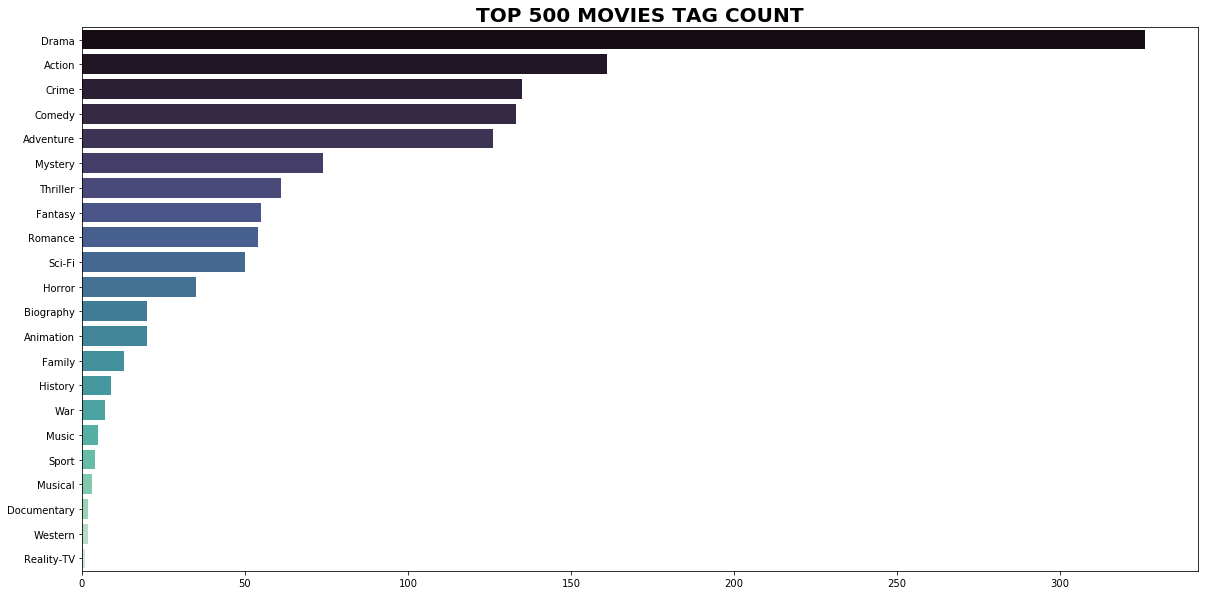

In [8]:
f, ax = plt.subplots(figsize=(20, 10))

sns.barplot(
    data=final_df,
    y=final_df.index,
    x=final_df['Genre Tag Count'].values,
    orient='h',
    palette='mako')


plt.title(label=f'TOP {len(imdb_movies)} MOVIES TAG COUNT', fontsize=20, fontweight='bold')
plt.show()

As we can see the three most used tags were "Drama", "Action" and "Crime".

### Let's find out which were the top 5 best rated movies based on the Ratings and Vote Count

If we sort our movies list only by their rating and vote count we get the following result. 
However it just doesn't seem fair that the movie "A Escuta" comes before the movie "O Poderoso Chefão" since their respective Rating and Vote Count are 9.3 and 286,600 and 9.2 and 1,630,338.

In [9]:
movies_df.loc[(movies_df['Rating'] != 'N/A') & (movies_df['Votes'] != 'N/A')].sort_values(by=['Rating', 'Votes'], ascending=False).head()

,Title,Release Year,Movie Runtime,Genres,Rating,Synopsis,Director,Stars,Votes,Gross
38,Breaking Bad,2008,49 min,"Crime, Drama, Thriller",9.5,A high school chemistry teacher diagnosed with...,N/A,"Bryan Cranston, Aaron Paul, Anna Gunn, Betsy B...",1472099,N/A
169,Um Sonho de Liberdade,1994,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2355900,$28.34M
11,Guerra dos Tronos,2011,57 min,"Action, Adventure, Drama",9.3,Nine noble families fight for control over the...,N/A,"Emilia Clarke, Peter Dinklage, Kit Harington, ...",1776297,N/A
118,A Escuta,2002,59 min,"Crime, Drama, Thriller",9.3,"The Baltimore drug scene, as seen through the ...",N/A,"Dominic West, Lance Reddick, Sonja Sohn, Wende...",286606,N/A
173,O Poderoso Chefão,1972,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,Francis Ford Coppola,"Marlon Brando, Al Pacino, James Caan, Diane Ke...",1630338,$134.97M


We could try a different approach and compare results. The approach would be to sort the movies based on the product between the average Rating and the Vote Count, which should give an advantage to those movies with a superior vote count.

In [10]:
df = movies_df.loc[(movies_df['Rating'] != 'N/A') & (movies_df['Votes'] != 'N/A')].copy(deep=True)
df['Average Rating'] = df['Rating'] * df['Votes']
df.sort_values(by='Average Rating', ascending=False)[movies_df.columns].head()

,Title,Release Year,Movie Runtime,Genres,Rating,Synopsis,Director,Stars,Votes,Gross
169,Um Sonho de Liberdade,1994,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",2355900,$28.34M
235,Batman: O Cavaleiro das Trevas,2008,152 min,"Action, Crime, Drama",9,When the menace known as the Joker wreaks havo...,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",2315354,$534.86M
222,A Origem,2010,148 min,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",2079330,$292.58M
11,Guerra dos Tronos,2011,57 min,"Action, Adventure, Drama",9.3,Nine noble families fight for control over the...,N/A,"Emilia Clarke, Peter Dinklage, Kit Harington, ...",1776297,N/A
400,Clube da Luta,1999,139 min,Drama,8.8,An insomniac office worker and a devil-may-car...,David Fincher,"Brad Pitt, Edward Norton, Meat Loaf, Zach Grenier",1864821,$37.03M


### Let's find out which were the best listed directors

In [11]:
directors_df = movies_df.loc[(movies_df['Director'] != 'N/A') & (movies_df['Rating'] != 'N/A')].copy(deep=True)
splitcount = max(directors_df['Director'].apply(lambda x: len(text_split(string=x, sep=', ')))) #Returns the maximum length of a movie Directors' list to be used to define the amount of individual Director columns to be created. 
for i in range(splitcount):
    directors_df[f'Director {i + 1}'] = directors_df['Director'].apply(lambda x: text_split(string=x, sep=', ', index=i))

    
final_directors_df = pd.DataFrame()
for col in directors_df.columns:
    if 'Director ' in col:
        final_directors_df = pd.concat([final_directors_df, directors_df.groupby(by=[col])[col].count().to_frame(name=col)], ignore_index=False, axis=1, sort=True)
        ratings_df = pd.DataFrame(directors_df[[col, 'Rating']])
        ratings_df = ratings_df.groupby(by=col)['Rating'].sum()
        rating_col = f'Rating {col.split(" ")[1]}'
        ratings_df = ratings_df.to_frame(name=rating_col)
        final_directors_df[rating_col] = pd.concat([final_directors_df, ratings_df], axis=1, sort=True)[rating_col]

final_directors_df.drop(index='N/A', inplace=True)
final_directors_df['Total Rating'] = final_directors_df[[col for col in final_directors_df.columns if 'Rating ' in col]].sum(axis=1)
final_directors_df['Movie Count'] = final_directors_df[[col for col in final_directors_df.columns if 'Director ' in col]].sum(axis=1)
final_directors_df = final_directors_df.filter(['Total Rating', 'Movie Count'])
final_directors_df['Average Rating'] = final_directors_df['Total Rating'] / final_directors_df['Movie Count']
final_directors_df = final_directors_df.round(2)
final_directors_df.index.rename('Director', inplace=True)
final_directors_df.sort_values(by=['Average Rating', 'Director'], ascending=[False, True]).head(10)

,Total Rating,Movie Count,Average Rating
Director,,,
Francis Ford Coppola,9.2,1.0,9.20
Frank Darabont,17.9,2.0,8.95
Peter Jackson,17.7,2.0,8.85
Jeethu Joseph,8.8,1.0,8.80
Lana Wachowski,8.7,1.0,8.70
Lilly Wachowski,8.7,1.0,8.70
Robert Zemeckis,17.3,2.0,8.65
Jonathan Demme,8.6,1.0,8.60
Luc Besson,8.5,1.0,8.50
